<a href="https://colab.research.google.com/github/rmDL4SON/Git_Practice/blob/main/CNN_Melanoma_Cancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

https://nbviewer.org/github/jagdishgg/Melanoma-Cancer-detection/blob/main/Jagdish_Galipelli_nn.ipynb
https://jovian.ai/shvmgrg98/starter-code-assignment-cnn-skin-cancer-ccf56#C1
laura.suchomska@gmail.com

### Importing all the important libraries

In [1]:
# conda install tensorflow

In [19]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob
import os
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D

from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
train_img_dir = '/content/drive/MyDrive/ComputerVision/SkinCancer-Detection/ISIC/Train'
test_img_dir = '/content/drive/MyDrive/ComputerVision/SkinCancer-Detection/ISIC/Test'

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [22]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset

data_dir_train = pathlib.Path(train_img_dir)
data_dir_test = pathlib.Path(test_img_dir)

In [23]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [24]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [25]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [26]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [27]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

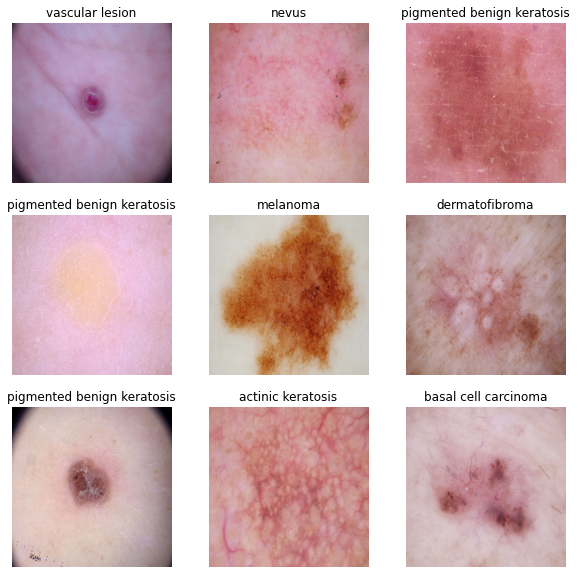

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis("off")


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [29]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [34]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]

### First Model without BatchNormalisation and no dropouts 

In [35]:
input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

## Number of classes is 9
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 conv2d_11 (Conv2D)          (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 88, 88, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 86, 86, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                  

In [36]:
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
loss='binary_crossentropy'

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [37]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

In [38]:
# View the summary of all layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 conv2d_11 (Conv2D)          (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 88, 88, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 86, 86, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                  

In [30]:
### Your code goes here
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [31]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [32]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 32)      2432      
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

### Train the model

In [39]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 183s 756ms/step - loss: nan - accuracy: 0.1719 - val_loss: nan - val_accuracy: 0.1499
Epoch 2/30
56/56 [==============================] - 2s 37ms/step - loss: nan - accuracy: 0.1228 - val_loss: nan - val_accuracy: 0.0492
Epoch 3/30
56/56 [==============================] - 2s 43ms/step - loss: nan - accuracy: 0.0513 - val_loss: nan - val_accuracy: 0.0492
Epoch 4/30
56/56 [==============================] - 2s 38ms/step - loss: nan - accuracy: 0.0513 - val_loss: nan - val_accuracy: 0.0492
Epoch 5/30
56/56 [==============================] - 2s 37ms/step - loss: nan - accuracy: 0.0513 - val_loss: nan - val_accuracy: 0.0492
Epoch 6/30
56/56 [==============================] - 2s 37ms/step - loss: nan - accuracy: 0.0513 - val_loss: nan - val_accuracy: 0.0492
Epoch 7/30
56/56 [==============================] - 2s 37ms/step - loss: nan - accuracy: 0.0513 - val_loss: nan - val_accuracy: 0.0492
Epoch 8/30
56/56 [==============================] - 

### Visualizing training results

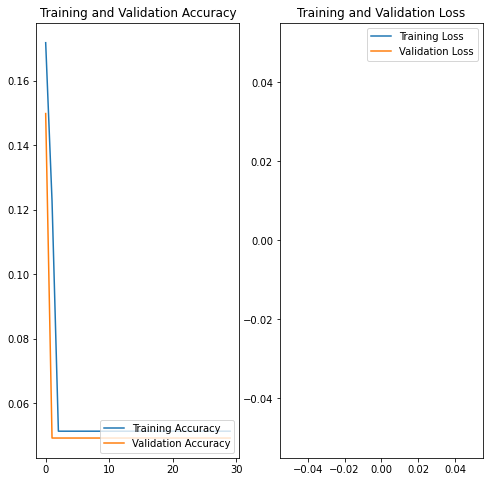

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 2nd model with batch normalisation and dropouts

In [ ]:
input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D  (pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D  (pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D  (pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

## Number of classes is 9
model.summary()

In [41]:
optimizer = 'adam'
loss_fn = "binary_crossentropy"
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 conv2d_11 (Conv2D)          (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 88, 88, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 86, 86, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                  

In [43]:
epochs = 20
batch_size = 32

history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 3s 44ms/step - loss: nan - accuracy: 0.0513 - val_loss: nan - val_accuracy: 0.0492
Epoch 2/20
56/56 [==============================] - 2s 39ms/step - loss: nan - accuracy: 0.0513 - val_loss: nan - val_accuracy: 0.0492
Epoch 3/20
56/56 [==============================] - 2s 37ms/step - loss: nan - accuracy: 0.0513 - val_loss: nan - val_accuracy: 0.0492
Epoch 4/20
56/56 [==============================] - 2s 37ms/step - loss: nan - accuracy: 0.0513 - val_loss: nan - val_accuracy: 0.0492
Epoch 5/20
56/56 [==============================] - 2s 38ms/step - loss: nan - accuracy: 0.0513 - val_loss: nan - val_accuracy: 0.0492
Epoch 6/20
56/56 [==============================] - 2s 37ms/step - loss: nan - accuracy: 0.0513 - val_loss: nan - val_accuracy: 0.0492
Epoch 7/20
56/56 [==============================] - 2s 38ms/step - loss: nan - accuracy: 0.0513 - val_loss: nan - val_accuracy: 0.0492
Epoch 8/20
56/56 [==============================] - 2s 

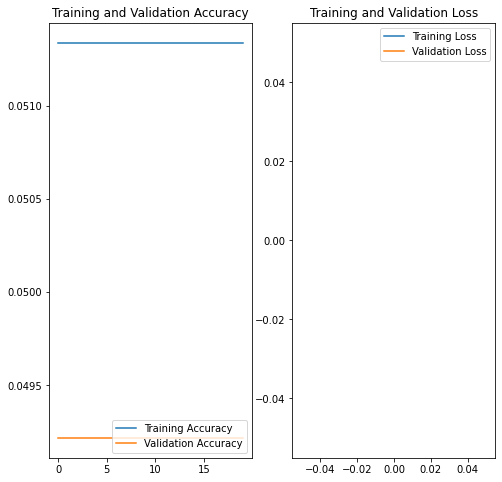

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

Finding on the first base model

The model is overfitting because we can also see difference in loss functions in training & test around the 10-11th epoch

The accuracy is just around 75-80% because there are enough features to remember the pattern.

But again, it's too early to comment on the overfitting & underfitting debate

In [45]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

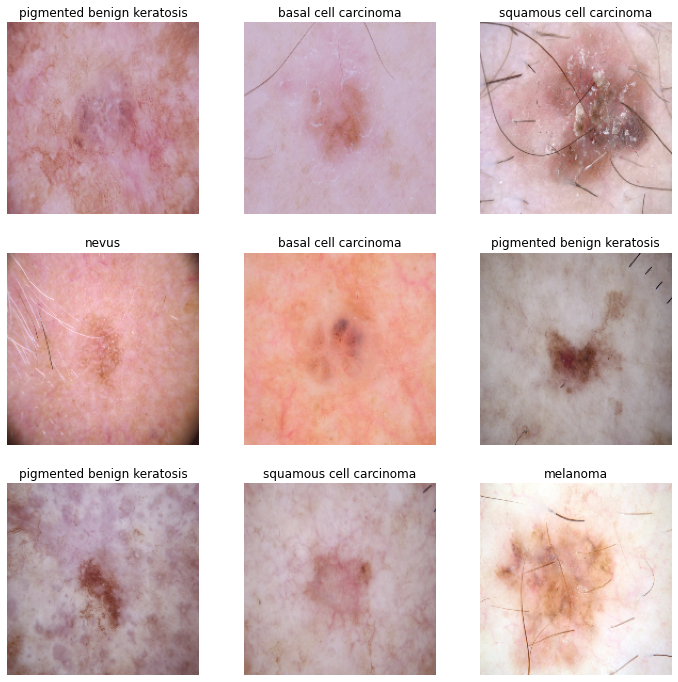

In [46]:
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [47]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))


### Compiling the model

In [48]:
### Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [49]:
## Your code goes here, note: train your model for 20 epochs
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 5s 60ms/step - loss: 2.0721 - accuracy: 0.2115 - val_loss: 1.9857 - val_accuracy: 0.2774
Epoch 2/30
56/56 [==============================] - 3s 55ms/step - loss: 1.9813 - accuracy: 0.2416 - val_loss: 2.0606 - val_accuracy: 0.2103
Epoch 3/30
56/56 [==============================] - 3s 55ms/step - loss: 2.0347 - accuracy: 0.1975 - val_loss: 2.0349 - val_accuracy: 0.1969
Epoch 4/30
56/56 [==============================] - 3s 55ms/step - loss: 2.0802 - accuracy: 0.2054 - val_loss: 2.0357 - val_accuracy: 0.2058
Epoch 5/30
56/56 [==============================] - 3s 56ms/step - loss: 2.0223 - accuracy: 0.2015 - val_loss: 2.0233 - val_accuracy: 0.2058
Epoch 6/30
56/56 [==============================] - 3s 56ms/step - loss: 2.0194 - accuracy: 0.2098 - val_loss: 2.0292 - val_accuracy: 0.2058
Epoch 7/30
56/56 [==============================] - 3s 56ms/step - loss: 2.0210 - accuracy: 0.2009 - val_loss: 2.0280 - val_accuracy: 0.2058
Epoch 8/30
56/56 [======

### Visualizing the results

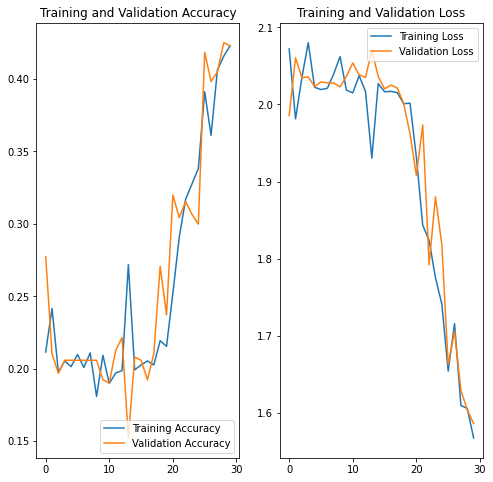

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**Finding from Second Model**

- There is no improvement in accuracy but we can definitely see the overfitting problem has solved due to data augmentation 

- We can increase the epochs to increase the accuracy so it's too early for judgement 

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [52]:
## Your code goes here.

##
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/ComputerVision/SkinCanc...,actinic keratosis
1,/content/drive/MyDrive/ComputerVision/SkinCanc...,actinic keratosis
2,/content/drive/MyDrive/ComputerVision/SkinCanc...,actinic keratosis
3,/content/drive/MyDrive/ComputerVision/SkinCanc...,actinic keratosis
4,/content/drive/MyDrive/ComputerVision/SkinCanc...,actinic keratosis
...,...,...
2234,/content/drive/MyDrive/ComputerVision/SkinCanc...,vascular lesion
2235,/content/drive/MyDrive/ComputerVision/SkinCanc...,vascular lesion
2236,/content/drive/MyDrive/ComputerVision/SkinCanc...,vascular lesion
2237,/content/drive/MyDrive/ComputerVision/SkinCanc...,vascular lesion


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [53]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/ComputerVision/SkinCanc...,actinic keratosis
1,/content/drive/MyDrive/ComputerVision/SkinCanc...,actinic keratosis
2,/content/drive/MyDrive/ComputerVision/SkinCanc...,actinic keratosis
3,/content/drive/MyDrive/ComputerVision/SkinCanc...,actinic keratosis
4,/content/drive/MyDrive/ComputerVision/SkinCanc...,actinic keratosis
...,...,...
2234,/content/drive/MyDrive/ComputerVision/SkinCanc...,vascular lesion
2235,/content/drive/MyDrive/ComputerVision/SkinCanc...,vascular lesion
2236,/content/drive/MyDrive/ComputerVision/SkinCanc...,vascular lesion
2237,/content/drive/MyDrive/ComputerVision/SkinCanc...,vascular lesion


In [56]:
#!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<BarContainer object of 9 artists>

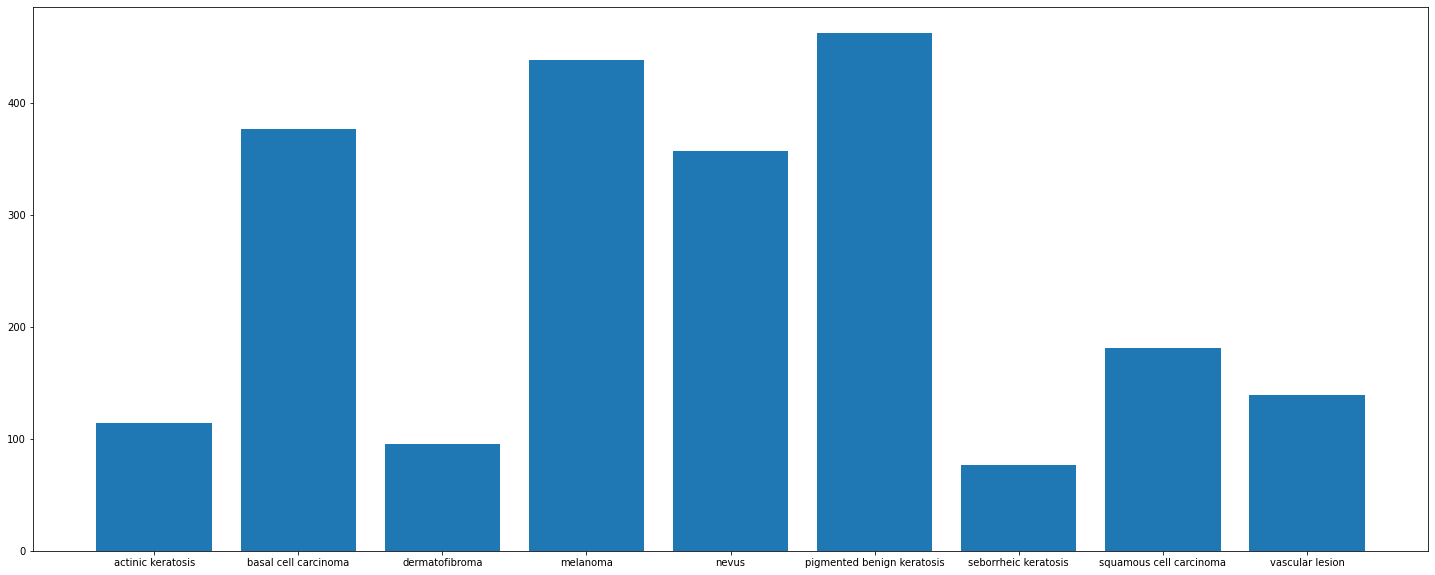

In [54]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [60]:
path_to_training_dataset="/content/drive/MyDrive/ComputerVision/SkinCancer-Detection/ISIC/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/ComputerVision/SkinCancer-Detection/ISIC/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F785D153CD0>: 100%|██████████| 500/500 [00:18<00:00, 27.45 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/ComputerVision/SkinCancer-Detection/ISIC/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F785D1536D0>: 100%|██████████| 500/500 [00:18<00:00, 26.45 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/ComputerVision/SkinCancer-Detection/ISIC/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F785DC1B150>: 100%|██████████| 500/500 [00:20<00:00, 24.71 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/ComputerVision/SkinCancer-Detection/ISIC/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F785D18EED0>: 100%|██████████| 500/500 [01:27<00:00,  5.73 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/ComputerVision/SkinCancer-Detection/ISIC/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7F785D10D990>: 100%|██████████| 500/500 [01:24<00:00,  5.91 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/ComputerVision/SkinCancer-Detection/ISIC/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F78608C7310>: 100%|██████████| 500/500 [00:18<00:00, 26.65 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/ComputerVision/SkinCancer-Detection/ISIC/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F787605A090>: 100%|██████████| 500/500 [00:43<00:00, 11.60 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/ComputerVision/SkinCancer-Detection/ISIC/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F78605CB950>: 100%|██████████| 500/500 [00:18<00:00, 27.58 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/ComputerVision/SkinCancer-Detection/ISIC/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F796C7092D0>: 100%|██████████| 500/500 [00:18<00:00, 27.09 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [61]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [62]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/MyDrive/ComputerVision/SkinCancer-Detection/ISIC/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027093.jpg_3ddfe769-dc34-4778-aa13-8e99c5cff0e2.jpg',
 '/content/drive/MyDrive/ComputerVision/SkinCancer-Detection/ISIC/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028989.jpg_89e4b706-d60a-4795-b741-78f9a8c01ae0.jpg',
 '/content/drive/MyDrive/ComputerVision/SkinCancer-Detection/ISIC/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027865.jpg_f027a801-91af-492e-9128-a03efa20b7f9.jpg',
 '/content/drive/MyDrive/ComputerVision/SkinCancer-Detection/ISIC/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0029392.jpg_67ed746d-4f5a-4d71-82c5-8d151fd6d6a7.jpg',
 '/content/drive/MyDrive/ComputerVision/SkinCancer-Detection/ISIC/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0031095.jpg_0e4df58f-26ae-4296-a7a0-2fa9af2d6468.jpg',
 '/content/drive/MyDrive/ComputerVision/SkinCancer

In [63]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',


In [65]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [66]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [67]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [68]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [71]:
data_dir_train="/content/drive/MyDrive/ComputerVision/SkinCancer-Detection/ISIC/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [72]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [73]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ 
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [74]:
## ### Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [75]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 180, 180, 32)      2432      
                                                                 
 conv2d_19 (Conv2D)          (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 90, 90, 64)        51264     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 45, 45, 64)       0         
 g2D)                                                 

#### **Todo:**  Train your model

In [76]:
epochs = 30

batch_size = 32

history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 33s 183ms/step - loss: 2.1893 - accuracy: 0.1419 - val_loss: 2.1919 - val_accuracy: 0.1411
Epoch 2/30
169/169 [==============================] - 31s 180ms/step - loss: 2.1749 - accuracy: 0.1419 - val_loss: 2.1920 - val_accuracy: 0.1403
Epoch 3/30
169/169 [==============================] - 32s 183ms/step - loss: 2.1798 - accuracy: 0.1411 - val_loss: 2.1887 - val_accuracy: 0.1403
Epoch 4/30
169/169 [==============================] - 32s 183ms/step - loss: 2.1877 - accuracy: 0.1435 - val_loss: 2.1922 - val_accuracy: 0.1418
Epoch 5/30
169/169 [==============================] - 31s 180ms/step - loss: 2.1756 - accuracy: 0.1491 - val_loss: 2.1792 - val_accuracy: 0.1425
Epoch 6/30
169/169 [==============================] - 33s 188ms/step - loss: 2.1525 - accuracy: 0.1725 - val_loss: 2.0914 - val_accuracy: 0.1923
Epoch 7/30
169/169 [==============================] - 36s 202ms/step - loss: 2.1798 - accuracy: 0.1843 - val_loss: 2.0676 - val_accuracy: 0.2

#### **Todo:**  Visualize the model results

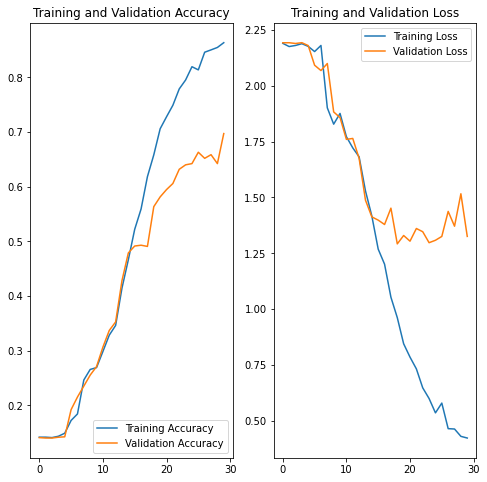

In [77]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



**bold text**- Accuracy on training data has increased by using Augmentor library

- Model is still overfitting

- The problem of overfitting can be solved by add more layer,neurons or adding dropout layers.

- The Model can be further improved by tuning the hyperparameter

Now lets try dropouts and simpler model to reduce the overfitting

In [78]:
model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(180, 180, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())



model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.4))


model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.4))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))


model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [79]:
# compile
model.compile(loss=tf.keras.metrics.sparse_categorical_crossentropy,
              optimizer='sgd',
              metrics=['accuracy'])

In [80]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_22 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 activation_2 (Activation)   (None, 180, 180, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_23 (Conv2D)          (None, 178, 178, 32)      9248      
                                                                 
 activation_3 (Activation)   (None, 178, 178, 32)      0         
                                                      

In [81]:
epochs = 30
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [82]:
history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs 
)

Epoch 1/30
169/169 [==============================] - 32s 180ms/step - loss: 2.2022 - accuracy: 0.3793 - val_loss: 4.9390 - val_accuracy: 0.1151
Epoch 2/30
169/169 [==============================] - 31s 177ms/step - loss: 1.2993 - accuracy: 0.5349 - val_loss: 1.9163 - val_accuracy: 0.3571
Epoch 3/30
169/169 [==============================] - 32s 185ms/step - loss: 1.0374 - accuracy: 0.6230 - val_loss: 1.2439 - val_accuracy: 0.5857
Epoch 4/30
169/169 [==============================] - 31s 177ms/step - loss: 0.8720 - accuracy: 0.6814 - val_loss: 0.8014 - val_accuracy: 0.7157
Epoch 5/30
169/169 [==============================] - 31s 177ms/step - loss: 0.7447 - accuracy: 0.7320 - val_loss: 0.6751 - val_accuracy: 0.7610
Epoch 6/30
169/169 [==============================] - 31s 178ms/step - loss: 0.6450 - accuracy: 0.7628 - val_loss: 0.8350 - val_accuracy: 0.7053
Epoch 7/30
169/169 [==============================] - 32s 185ms/step - loss: 0.5619 - accuracy: 0.7925 - val_loss: 0.5557 - val_ac

In [83]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

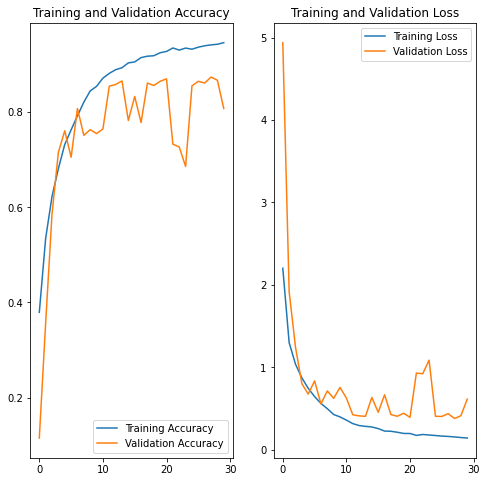

In [84]:
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [86]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Train Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Train Loss: ",loss)
print("Validation Loss", loss_v)

43/43 [==============================] - 6s 112ms/step - loss: 0.6143 - accuracy: 0.8077
Train Accuracy:  0.9235904812812805
Validation Accuracy:  0.8077208399772644
Train Loss:  0.20808890461921692
Validation Loss 0.6143155097961426
